# Libraries

In [ ]:
import pandas as pd
import numpy as np
import QuantLib as ql
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Risk Free Rate

In [3]:
swap_curve = pd.read_excel("YieldCurveData.xlsx")

swap_curve.columns = swap_curve.iloc[3]
swap_curve = swap_curve.drop([0, 1, 2, 3])
swap_curve_new = swap_curve.iloc[:, :2].copy()
swap_curve_new['Dates'] = pd.to_datetime(swap_curve_new['Dates'])
filtered_swap_curve = swap_curve_new[(swap_curve_new['Dates'] >= '2021-10-18') & (swap_curve_new['Dates'] <= '2021-12-17')].set_index('Dates',drop=True)
rate = filtered_swap_curve.copy()
rate = rate / 100

rate.head()

3,PX_LAST
Dates,
2021-10-18,0.001315
2021-10-19,0.001295
2021-10-20,0.001283
2021-10-21,0.001239
2021-10-22,0.001249


In [4]:
def get_price(ETF):
    # read excel file
    df = pd.read_excel('Project 3 Data.xlsx', sheet_name = ETF)

    # Set new column names
    df.columns = df.iloc[3]

    # Drop the first four rows
    df = df.drop([0, 1, 2, 3])

    # Create a new DataFrame with only the first two columns
    df_new = df.iloc[:, :2].copy()

    # Convert the 'Dates' column to datetime format
    df_new['Dates'] = pd.to_datetime(df_new['Dates'])

    # Filter the DataFrame based on the date range
    ETF_prices = df_new[(df_new['Dates'] >= '2021-10-18') & (df_new['Dates'] <= '2021-12-17')].set_index('Dates',drop=True).copy()

    return ETF_prices

In [5]:
def get_vol(ETF):
    # read excel file
    df = pd.read_excel('Project 3 Data.xlsx', sheet_name = ETF,usecols = 'A, F')

    # Drop the first four rows
    df = df.drop([0, 1, 2, 3])

    # Set index as date
    df = df.set_index(df.columns[0])

    # Rename
    df.index.name = 'Date'

    # Filter the DataFrame based on the date range
    vol = df[(df.index >='2021-10-18')& (df.index <='2021-12-17')]

    # Rename col
    vol = vol.rename(columns = {vol.columns[0]:'vol'})
    
    return vol

In [6]:
ETFs = ["XLU", "XLB", "XLRE", "XLE", 
        "XLP", "XLI", "XLC", "XLF", 
        "XLY", "XLV", "XLK", "SPX"]

# dictionary to store prices
price = {}

for etf in ETFs:
    price[etf] = get_price(etf)

In [7]:
call = {}
put = {}

# store all ETF call
for etf in ETFs:
    df = rate.merge(get_price(etf), left_index = True, right_index = True)
    df=df.merge(get_vol(etf),left_index = True, right_index = True )
    df.rename(columns = {df.columns[0]: 'rates'}, inplace = True)
    df.rename(columns = {df.columns[1]: 'prices'}, inplace = True)
    call[etf] = df

# store all ETF put
for etf in ETFs:
    df= rate.merge(get_price(etf), left_index = True, right_index = True)
    df=df.merge(get_vol(etf),left_index = True, right_index = True )
    df.rename(columns = {df.columns[0]: 'rates'}, inplace = True)
    df.rename(columns = {df.columns[1]: 'prices'}, inplace = True)
    put[etf] = df

# Portfolio Construction

## 1. Starting with short -1000 ATM SPX Straddle (Both Call and Put options)

In [8]:
#funciton to calculate the price and delta for straddle
def get_prices(ETF, type):

    if type == "call":
        df = call[ETF]
    elif type == "put":
        df = put[ETF]
    else:
        raise ValueError("Invalid type. Type must be 'call' or 'put'.")

    results = []

    for i in range(len(df)):
        S = df.iloc[i]['prices']  # Get the current price
        R = df.iloc[i]['rates']   # Get the current rate
        K = df.iloc[0]['prices']  #K should be the same as of the first day
        calculation_date = ql.Date.from_date(df.iloc[i].name.to_pydatetime()) 

        if type == "call":
            option_type = ql.Option.Call
        elif type == "put":
            option_type = ql.Option.Put
        else:
            raise ValueError("Invalid type. Type must be 'call' or 'put'.")

        maturity_date = ql.Date.from_date(df.iloc[-1].name.to_pydatetime())
        dividend_rate = 0.0 

        iv = df.iloc[i]['vol'] / 100
        day_count = ql.Actual365Fixed()
        
        calendar = ql.UnitedStates(ql.UnitedStates.NYSE)
        ql.Settings.instance().evaluationDate = calculation_date

        payoff = ql.PlainVanillaPayoff(option_type, K)
        exercise = ql.EuropeanExercise(maturity_date)
        european_option = ql.VanillaOption(payoff, exercise)

        spot_handle = ql.QuoteHandle(ql.SimpleQuote(S))
        flat_ts = ql.YieldTermStructureHandle(ql.FlatForward(calculation_date, R, day_count))

        dividend_yield = ql.YieldTermStructureHandle(ql.FlatForward(calculation_date, dividend_rate, day_count))
        flat_vol_ts = ql.BlackVolTermStructureHandle(ql.BlackConstantVol(calculation_date, calendar, iv, day_count))
        bsm_process = ql.BlackScholesMertonProcess(spot_handle, dividend_yield, flat_ts, flat_vol_ts)

        european_option.setPricingEngine(ql.AnalyticEuropeanEngine(bsm_process))
        bs_price = european_option.NPV()
        delta = european_option.delta()

        results.append({
            "Date": df.index[i],
            "Stock Price": S,
            "Option Quantity":1000,
            "BS Price": bs_price,
            'Vol':iv,
            'r':R,
            "Delta": delta,   
        })
    
    return pd.DataFrame(results)

In [9]:
#dictionary to store call and put price for each sector and SPX and merged them together to get total price and total delta
call_prices = {}
put_prices = {}
merged_data = {}

for etf in ETFs:
    #get call and put price
    call_prices[etf] = get_prices(etf, 'call')
    put_prices[etf] = get_prices(etf, 'put')

    call_prices[etf] = call_prices[etf].set_index('Date',drop=True)
    put_prices[etf] = put_prices[etf].set_index('Date',drop=True)

    call_prices[etf] = call_prices[etf].rename(columns = {'BS Price':'Call Price','Delta':'Call Delta'})
    put_prices[etf] = put_prices[etf].rename(columns = {'BS Price':'Put Price','Delta':'Put Delta'})

    call_prices[etf] = call_prices[etf][['Call Price','Call Delta']]
    #merge them together
    merged_data[etf] = pd.merge(put_prices[etf],call_prices[etf],left_index=True, right_index=True)
    #calculate total price/total premium
    merged_data[etf]['Total Price'] = merged_data[etf]['Call Price'] + merged_data[etf]['Put Price']
    #calculate total delta
    merged_data[etf]['Total Delta'] = (merged_data[etf]['Call Delta'] + merged_data[etf]['Put Delta'])

    if etf == 'SPX':
        #calclate spx onl since we are shorting straddle
        merged_data[etf][f'{etf} PnL'] = merged_data[etf]['Total Price'].diff()*1000*(-1)
        #calculate spx hedge pnl
        merged_data[etf][f'{etf} Hedge PnL'] = merged_data[etf]['Stock Price'].diff()*merged_data[etf]['Total Delta'].shift(1)*1000

In [10]:
merged_data["SPX"].head()

,Stock Price,Option Quantity,Put Price,Vol,r,Put Delta,Call Price,Call Delta,Total Price,Total Delta,SPX PnL,SPX Hedge PnL
Date,,,,,,,,,,,,
2021-10-18,4486.46,1000,90.351096,0.1252,0.001315,-0.488177,91.320804,0.511823,181.671900,0.023645,NaN,NaN
2021-10-19,4519.63,1000,70.950784,0.1204,0.001295,-0.428302,105.059831,0.571698,176.010614,0.143397,5661.285588,784.309546
2021-10-20,4536.19,1000,61.578439,0.1178,0.001283,-0.396441,112.222662,0.603559,173.801102,0.207117,2209.512735,2374.651676
2021-10-21,4549.78,1000,52.690421,0.1134,0.001239,-0.367130,116.878271,0.632870,169.568692,0.265741,4232.409302,2814.725210
2021-10-22,4544.90,1000,56.531313,0.1174,0.001249,-0.378815,115.830821,0.621185,172.362134,0.242369,-2793.441816,-1296.815560


## 2. Long straddle for each ETF

Long straddle for each ETF, for XLK for example, the number of straddles we long should be 211.92 * 1000 * 27.91% / 9.28 = 6,373

Long straddle for each ETF, for XLV for example, the number of straddles we long should be 211.92 * 1000 * 12.69% / 6.35 = 4235

In [11]:
sector_weights={'XLK':27.914488 / 100,
                'XLV':12.692172 / 100,
                'XLY':12.618698 / 100,
                'XLF':11.499232 / 100,
                'XLC':11.042944 / 100,
                'XLI':8.127506 / 100,
                'XLP':5.670948 / 100,
                'XLE':2.924949 / 100,
                'XLRE':2.579896 / 100,
                'XLB':2.527329 / 100,
                'XLU':2.401839 / 100,
                }

In [12]:
merged_data["XLU"].head(10)

,Stock Price,Option Quantity,Put Price,Vol,r,Put Delta,Call Price,Call Delta,Total Price,Total Delta
Date,,,,,,,,,,
2021-10-18,64.5431,1000,1.549579,0.149137,0.001315,-0.486515,1.563529,0.513485,3.113108,0.026970
2021-10-19,65.3567,1000,1.038544,0.135742,0.001295,-0.397179,1.865653,0.602821,2.904197,0.205642
2021-10-20,66.3886,1000,0.717619,0.140562,0.001283,-0.296395,2.576271,0.703605,3.293890,0.407210
2021-10-21,66.3886,1000,0.673706,0.136904,0.001239,-0.290568,2.531691,0.709432,3.205397,0.418864
2021-10-22,66.7259,1000,0.603024,0.140707,0.001249,-0.262875,2.798189,0.737125,3.401213,0.474250
2021-10-25,66.4382,1000,0.437117,0.115280,0.001345,-0.246613,2.344821,0.753387,2.781938,0.506773
2021-10-26,66.7954,1000,0.644924,0.153334,0.001359,-0.266001,2.909717,0.733999,3.554642,0.467998
2021-10-27,66.3489,1000,0.684070,0.144555,0.001286,-0.294248,2.501470,0.705752,3.185540,0.411503
2021-10-28,66.7855,1000,0.593240,0.149602,0.001316,-0.258573,2.847277,0.741427,3.440517,0.482853


In [13]:
new_ETFs = ["XLU", "XLB", "XLRE", "XLE", 
            "XLP", "XLI", "XLC", "XLF", 
            "XLY", "XLV", "XLK"]

long_straddle = {}

for etf in new_ETFs:
    results_list = []  # List to accumulate each row of results
    for i in range(len(merged_data['SPX'])):
        date_i = merged_data['SPX'].index[i]
        spx_price = merged_data['SPX'].iloc[i]['Total Price']
        share = 1000
        weight = sector_weights[etf]
        etf_price = merged_data[etf].iloc[i]['Total Price'] 
        #calculate number of straddle to long for each sector
        ratio = (spx_price * share * weight) / etf_price

        # Append the result as a dictionary to the list
        results_list.append({
            'Date': date_i,
            'Sector': etf,
            'Straddles': ratio
        })

    long_straddle[etf] = pd.DataFrame(results_list).set_index("Date")

long_straddle['XLU'].head()


,Sector,Straddles
Date,,
2021-10-18,XLU,1401.643258
2021-10-19,XLU,1455.648810
2021-10-20,XLU,1267.323046
2021-10-21,XLU,1270.596644
2021-10-22,XLU,1217.171812


In [14]:
#calculate long straddle delta hedge
#previous delta*stock price difference*number of straddle
long_straddle_hedge_pnl = {}

for etf in new_ETFs:
    delta_hedge_pnl = (-1) * merged_data[etf]['Stock Price'].diff() * long_straddle[etf]['Straddles'] * merged_data[etf]['Total Delta'].shift(1)
    long_straddle_hedge_pnl[etf] = delta_hedge_pnl
#sum all the long straddle delta hedge by day
hedge_pnl_df = pd.DataFrame(long_straddle_hedge_pnl)
total_long_straddle_hedge_pnl_by_day = hedge_pnl_df.sum(axis=1)
total_long_straddle_hedge_pnl_by_day

Date
2021-10-18        0.000000
2021-10-19     -764.683782
2021-10-20    -2205.970759
2021-10-21     -894.250737
2021-10-22      245.734819
2021-10-25    -1703.545153
2021-10-26    -1947.997532
2021-10-27     7323.097725
2021-10-28    -7544.057690
2021-10-29    -2590.622710
2021-11-01    -3400.048425
2021-11-02    -4945.618013
2021-11-03    -9967.443299
2021-11-04    -6300.648538
2021-11-05    -4517.100492
2021-11-08      801.730829
2021-11-09     7430.911870
2021-11-10    11912.476819
2021-11-11     -205.855334
2021-11-12    -8860.296704
2021-11-15      600.465960
2021-11-16    -7912.322631
2021-11-17     3251.571764
2021-11-18    -4460.474271
2021-11-19     1003.427555
2021-11-22     9358.153007
2021-11-23     1209.258464
2021-11-24    -3797.067662
2021-11-26    46777.359120
2021-11-29   -14694.730056
2021-11-30    20313.929567
2021-12-01     7252.179856
2021-12-02     5300.687488
2021-12-03    13570.101839
2021-12-06    -2903.898343
2021-12-07   -23109.780451
2021-12-08    -5165.888

In [15]:
#calculate long straddle pnl by multiplying total option price difference*number of straddle
long_straddle_pnl = {}
for etf in new_ETFs:
    pnl = merged_data[etf]['Total Price'].diff() * long_straddle[etf]['Straddles']
    long_straddle_pnl[etf] = pnl
#sum total pnl by day for 11 sectors
pnl_df = pd.DataFrame(long_straddle_pnl)
total_long_straddle_pnl_by_day = pnl_df.sum(axis=1)
total_long_straddle_pnl_by_day.head()


Date
2021-10-18       0.000000
2021-10-19   -1277.676727
2021-10-20   -4737.763919
2021-10-21   -3457.722862
2021-10-22    9069.223979
dtype: float64

In [16]:
#SPX PnL
merged_data['SPX']['SPX PnL'].head()

Date
2021-10-18            NaN
2021-10-19    5661.285588
2021-10-20    2209.512735
2021-10-21    4232.409302
2021-10-22   -2793.441816
Name: SPX PnL, dtype: float64

In [17]:
#SPX Hedge PnL
merged_data['SPX']['SPX Hedge PnL'].head()

Date
2021-10-18            NaN
2021-10-19     784.309546
2021-10-20    2374.651676
2021-10-21    2814.725210
2021-10-22   -1296.815560
Name: SPX Hedge PnL, dtype: float64

In [18]:
#merge data together to get the final total pnl
df_final = pd.DataFrame(merged_data['SPX'][['SPX PnL', 'SPX Hedge PnL']]).copy()
a = pd.DataFrame(total_long_straddle_pnl_by_day)
b = pd.DataFrame(total_long_straddle_hedge_pnl_by_day)
df_final['ETF Straddle PnL'] = a
df_final['ETF Hedge PnL'] = b
df_final['Total PnL'] = df_final['SPX PnL'] + df_final['SPX Hedge PnL'] + df_final['ETF Straddle PnL'] + df_final['ETF Hedge PnL']
df_final

,SPX PnL,SPX Hedge PnL,ETF Straddle PnL,ETF Hedge PnL,Total PnL
Date,,,,,
2021-10-18,NaN,NaN,0.000000,0.000000,NaN
2021-10-19,5661.285588,784.309546,-1277.676727,-764.683782,4403.234625
2021-10-20,2209.512735,2374.651676,-4737.763919,-2205.970759,-2359.570267
2021-10-21,4232.409302,2814.725210,-3457.722862,-894.250737,2695.160913
2021-10-22,-2793.441816,-1296.815560,9069.223979,245.734819,5224.701422
2021-10-25,1269.419233,5230.328816,-2798.503633,-1703.545153,1997.699264
2021-10-26,-9202.876173,2766.370183,12182.862686,-1947.997532,3798.359164
2021-10-27,-3260.751364,-8086.369867,-4600.545271,7323.097725,-8624.568775
2021-10-28,-3220.748293,11371.761795,-6363.441238,-7544.057690,-5756.485426


In [19]:
#check total pnl on maturity day
df_final['Total PnL'].sum()

-1399.8256963398308

$$\rho = \dfrac{\sigma_{index}^{2} - \sum w_{i}^{2} \sigma_{sector}^{2}}{\sum_{i} \sum_{j \neq i} w_{i}w_{j} \sigma_{i}\sigma_{j}}$$

In [20]:
sigma_index_implied = (merged_data['SPX'].iloc[0]['Vol'])**2

sum_vol_squared_1 = 0
for etf in sector_weights:
    sum_vol_squared_1 += ((sector_weights[etf])**2) * (merged_data[etf].iloc[0]['Vol']**2)

sum_vol_squared_2 = 0
for etf_i in sector_weights:
    for etf_j in sector_weights:
        if etf_i != etf_j:
            sum_vol_squared_2 += sector_weights[etf_i] * sector_weights[etf_j] * merged_data[etf_i].iloc[0]['Vol'] * merged_data[etf_j].iloc[0]['Vol']

implied_correlation = (sigma_index_implied - sum_vol_squared_1) / sum_vol_squared_2
implied_correlation

0.5628343649903171

In [21]:
sigma_index_realized = (merged_data['SPX']['Stock Price'].pct_change().std())**2

sum_vol_squared_1 = 0
for etf in sector_weights:
    sum_vol_squared_1 += ((sector_weights[etf])**2) * (merged_data[etf]['Stock Price'].pct_change().std()**2)

sum_vol_squared_2 = 0
for etf_i in sector_weights:
    for etf_j in sector_weights:
        if etf_i != etf_j:
            sum_vol_squared_2 += sector_weights[etf_i] * sector_weights[etf_j] * merged_data[etf_i]['Stock Price'].pct_change().std() * merged_data[etf_j]['Stock Price'].pct_change().std()

realized_correlation = (sigma_index_realized - sum_vol_squared_1) / sum_vol_squared_2
realized_correlation

0.5250988839864426

In [22]:
implied_correlation - realized_correlation

0.03773548100387458

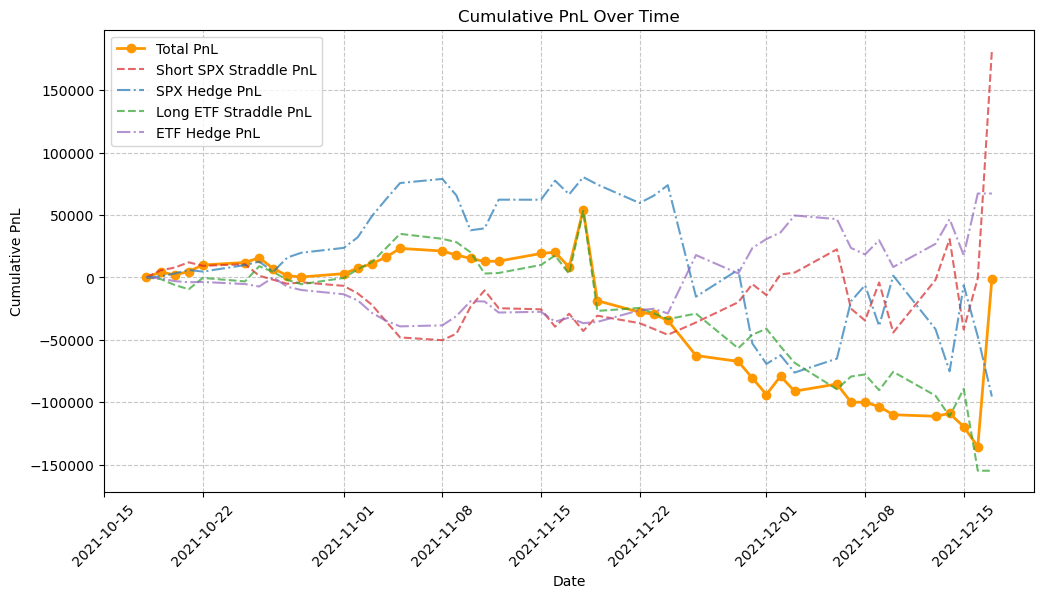

In [ ]:
df_final.iloc[0] = df_final.iloc[0].fillna(0)

df_cumsum = df_final.cumsum()

plt.figure(figsize=(12,6))


plt.plot(df_cumsum.index, df_cumsum['Total PnL'], label='Total PnL', color='#ff9800', linewidth=2, marker = "o")

plt.plot(df_cumsum.index, df_cumsum['SPX PnL'], '--', color='#d62728' , label = 'Short SPX Straddle PnL', linewidth = 1.5, alpha = 0.7)
plt.plot(df_cumsum.index, df_cumsum['SPX Hedge PnL'], '-.', color='#1f77b4', label = 'SPX Hedge PnL', linewidth=1.5, alpha = 0.7)
plt.plot(df_cumsum.index, df_cumsum['ETF Straddle PnL'], '--', color='#2ca02c', label = 'Long ETF Straddle PnL', linewidth=1.5, alpha = 0.7)
plt.plot(df_cumsum.index, df_cumsum['ETF Hedge PnL'], '-.', color='#9467bd', label = 'ETF Hedge PnL', linewidth=1.5, alpha = 0.7)

plt.xlabel("Date")
plt.ylabel("Cumulative PnL")
plt.title("Cumulative PnL Over Time")
plt.legend()
plt.xticks(rotation=45)
plt.grid(linestyle="--", alpha=0.7)
plt.show()
